# Quantitative Biology and Biophysics (AS.020.674/618)	Spring 2024
# Lab 2: Gordus 
# February 16, 2024

#  Numerical Methods & Dimension Reduction

In this lab we'll learn how to use two valuable tools, nlinfit and ode. We will test embedding using tSNE and UMAP.

**You will need to pip insall the umap library**

`pip install umap-learn`

## Libraries you will need

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import time
import umap.umap_ as umap


# Problem 1: Curve Fitting

In class, we discussed the Hill Equation:

<img src="http://www.gordus.org/public_images/hill.png" style="width: 300px;"/>


The `f_bound` data you load below is the fraction of protein bound by ligand at the following ligand nanomolar concentrations:

`L = 10,20,50,100,150,200,300,400]`





## Step 1: Load the data

## <font color='red'>Student Input Cell: 1 point</font> 

In [104]:
file_path = '/Users/cmdb/Desktop/QBIO2_lab/lab_2/'
fname  = 'lab_2_data.npy'

f_bound = np.load(file_path+fname)


## Step 2: Plot the data

## <font color='red'>Student Input Cell: 1 point</font> 


Text(0, 0.5, '% of protein bound by ligand')

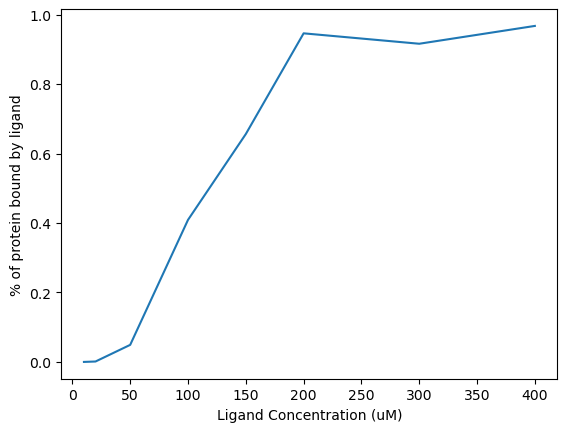

In [105]:
#--------------------------------#
# Plot the f_bound values vs. L. #
#--------------------------------#
L = [10,20,50,100,150,200,300,400]

plt.plot(L,f_bound)
plt.xlabel("Ligand Concentration (uM)")
plt.ylabel("% of protein bound by ligand")

## Step 3: Define a function for the Hill Equation

To fit a Hill equation curve to this data, we should first define a function for the Hill equation.

## Complete the function below.

**Note:** `p0` is an array of the parameters you are trying to optimize for this function.

## <font color='red'>Student Input Cell: 5 points</font> 


In [106]:
def hill_eq(p0,L):
    n = p0[0] 
    Ka = p0[1] 
    hill_pred = (L**n) / (Ka**n + L**n)
    return hill_pred


## Step 4: Define residual function

Once you've defined your equation, you need to define some metric that quantifies the difference between the data and your prediction. There are many ways to do this. To make things easy, simply compute the sum of the absolute difference of the model to the data, i.e.:

<img src="http://www.gordus.org/public_images/fbound.png" style="width: 600px;"/>

Your function should have two inputs: the parameters for the Hill equation, and your observed data (Ligand concentration and f_bound. You'll call `hill_eq` in your residual function, below.

## Complete the function below. 

## <font color='red'>Student Input Cell: 5 points</font> 

In [107]:
data = np.array([L,f_bound])

def residual(p0,data):
    distance = np.nansum(np.abs(data - hill_eq(p0,L)))
    return distance


## Step 5: Perform minimization

Now that you have a residual function to minimize, you can use the `minimize` function you imported earlier (and was used in the last lab!). Scipy has other optimizers such as `curvefit`, but I am a fan of `minimize` because it offers gradient-free solvers such as Nelder-Mead. The standard syntax is:

`output_object = minimize(function, p0, args=data, method='Nelder-Mead')`

**Input:**

1. `function`: This is the residual function you are trying to minimize. The first argument of this function should be the parameters, followed by the data you are trying to fit to, i.e. ` function(p0,x)`. You'll notice we used the correct format when we defined the residual function above.
2. `p0`: These are your initial guesses for what the parameters might be. The order in which you enter them into this array should match the order in which they are called in the function.
3. `args`: These are the observed data (in your case, the f_bound data).
4. `method`: The algorithm used to find the minimum. There are several options, but for this lab, you'll choose `Nelder-Mead`.

**Output:**

1. `output_object`: This is an object with several attributes. For your purposes, you will want "x", the optimized parameters: `output_object.x`.

## Do the following.

1. Use minimize to estimate Ka & n for the imported data. Use the plot to make initial guesses for what Ka & n might be.
2. Plot a continuous version of your predicted Hill equation from L = 0-> 400.
3. Plot the original data on this plot **as discrete data points**. Does the prediction look correct?
4. Print the optimized parameters

## <font color='red'>Student Input Cell: 5 points</font> 

Text(0, 0.5, '% of protein bound by ligand')

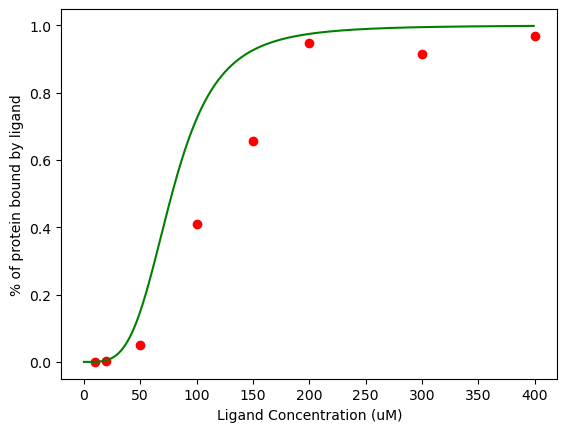

In [108]:
p0 = [3, 125]
output_object = minimize(residual, p0, args = data, method = 'Nelder-Mead')
p0 = output_object.x 
Lnum = range(0,400)
actual = hill_eq(p0, Lnum)

plt.plot(Lnum, actual, color = 'green')
plt.scatter(L, f_bound, color = 'red')
plt.xlabel("Ligand Concentration (uM)")
plt.ylabel("% of protein bound by ligand")

For more information on how the minimize function works, see:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

# Problem 2: Solving ODEs with Runge-Kutta algorithms

The `scipy.integrate` library has a variety of integration tools. One of the tools in this library is the `solve_ivp` function. It's an easy-to-use ODE solver for an initial value problem for a system of ODEs.

In class I discussed a simple compartment model used in epidemiology, the SIR (Susceptible, Infected, Recovered) model. This forms the basis for many other, more complicated models. In many ways, it is very similar to the types of equations used to model chemical dynamics. For example, to create a new infected person, an infected person must come into contact with a susceptible person, therefore the kinetic term is the product of these two popualtions, just like an enzyme coming into contact with its substrate. The following is a flow diagram for disease progression:

 

The ordinary differential equations (ODEs) are:

dS/dt= -βSI

dI/dt= βSI- γI

dR/dt=(1-f)γI

dD/dt=fγI


Where:

S = Susceptible population

I = Infected population

R = Recovered population

β = disease transmission rate

γ = recovery rate

f = fraction of infected that die

<div>
<img src="http://www.gordus.org/public_images/SIR1.png" />
</div>

## New York COVID Outbreak in 2020

For this problem, we are going to model the progression of COVID in NYC in , using parameters and population numbers gathered from public data during the time when the shelter in place order was put in place. For these calculations, to make things a little easier, we are normalizing all population numbers by the total population of NYC. When COVID first spread through the city, it grew with exponential growth, because:

dI/dt= βSI

At day t=0, there were 30 confirmed COVID cases. By day 12, there were 17,644 confirmed cases in the city. At this point, the city instituted a lockdown order, with the hopes of ebbing the spread of the disease. By day 52, the number of confirmed cases had risen to 167,000. The question here is did the lockdown order have an effect? What would the numbers had been like without any intervention?

Below are the parameters for the model based on observed rates of transmission and city statistics:

In [109]:
# Set Variables
# NOTE: Timescale is days
NYC_pop = 8*np.power(10,6)
S0 = 1 # Actual NYC population: 8*np.power(10,6)
I0 = 30 / NYC_pop


R0 = 2.2
gamma = 0.44 #the units are day^-1
beta = R0*gamma/S0 #the units are (population fraction*day)^-1

# NYC Stats on day 52
Conf = 167000 #52 days from t0
Dead = 13000 #52 days from t0
Rec = 40000 #52 days from t0

# Shelter in Place occurred t = 12 days
# Confirmed cases was ~17644 at this point

f = Dead/Conf

## Step 1: Define the model

Write a function that defines the SIR ODEs.

**NOTE:** For the solver to work, it requires your ODE function to have as input the independent variable (in this case, "time") and the dependent variables (in this case, Susceptible and Infected). **HOWEVER**, the "time" variable will not **explicitly** be used in your function.

## <font color='red'>Student Input Cell: 5 points</font> 


The ordinary differential equations (ODEs) are:

dS/dt= -βSI

dI/dt= βSI- γI

dR/dt=(1-f)γI

dD/dt=fγI


Where:

S = Susceptible population

I = Infected population

R = Recovered population

β = disease transmission rate

γ = recovery rate

f = fraction of infected that die

In [110]:
# SIR ODE, returns the following:
y = [S0,I0,R0,Dead]

def SIR(t,y):
    dSdt = -1*beta*y[0]*y[1]
    dIdt = (beta*y[0]*y[1]) - (gamma*y[1])
    dRdt = (1-f)*gamma*y[1]
    dDdt = f*gamma*y[1]
    return np.array([dSdt, dIdt, dRdt,dDdt])

## Step 2: Predict the progression of infection for the first 52 days if no shelter-in-place order was put into effect.


## The solve_ivp integrator

The `solve_ivp` function has the following syntax:

`solution_object = solve_ivp(fun, t_span, y0, method='RK45')`

**Input:**

1. `fun`: The ODE function, i.e. the time derivative of the state y at time t. The calling signature is fun(t, y), where t is a scalar and y is an ndarray with len(y) = len(y0). Additional arguments need to be passed if args is used (see documentation of args argument). fun must return an array of the same shape as y.
2. `t_span`: Interval of integration (t0, tf). The solver starts with t=t0 and integrates until it reaches t=tf.
3. `y0`: Initial state, i.e. in this case, the initial values of S, I, R and D.
4. `method`: The default is `RK45` which is a 5th order Runge-Kutta algorithm. There are other method options as well, most of which rely on Runge-Kutta.

**NOTE:** For the solver to work, it requires your ODE function to have as input the independent variable (in this case, "time") and the dependent variables (in this case, Susceptible and Infected). **HOWEVER**, the "time" variable will not **explicitly** be used in your function.

**Output:**

`solution_object`: An object with several attributes. For your purposes, the two attributes you will want are:

1. t: time points used.
2. y: values of the solution at t.


## Do the following:

Use the solver to predict the fraction of the Susceptible, Infected, Recovered, and Dead populations from day 0 to day 52, assuming no intervention was made.

## <font color='red'>Student Input Cell: 5 points</font> 

In [111]:
# Without Intervention
sol_no_int = solve_ivp(SIR, [0,51],[S0,I0,0,0])
print(sol_no_int)


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.809e-01 ...  5.060e+01  5.100e+01]
        y: [[ 1.000e+00  1.000e+00 ...  1.555e-01  1.554e-01]
            [ 3.750e-06  4.585e-06 ...  2.189e-04  1.947e-04]
            [ 0.000e+00  6.419e-07 ...  7.786e-01  7.786e-01]
            [ 0.000e+00  5.419e-08 ...  6.573e-02  6.573e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 116
     njev: 0
      nlu: 0


## Step 3: Predict the progression of infection for the first 52 days if the shelter-in-place order was put into effect on day 12.

Predict what would happen if you intervened on day t=12 with the shelter in place order. Assume this decreases the number of susceptible people (S) by 42%.

**NOTE:** This decrease in the Susceptible population will be 42% of the Susceptible population **ON DAY 12**.

## <font color='red'>Student Input Cell: 5 points</font> 

In [112]:
# With Intervention (Note the change in S0 after day 12)
sol_w_int = solve_ivp(SIR, [11,51],[(0.42*S0),(Conf / NYC_pop), 0, 0]) #DON'T WE NEED TO CHANGE # OF DEAD AND RECOVERED TO REFLECT STATS ON DAY 12?
print(sol_w_int)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.100e+01  1.107e+01  1.182e+01  1.931e+01  2.991e+01
             3.875e+01  4.759e+01  5.100e+01]
        y: [[ 4.200e-01  4.194e-01 ...  3.281e-01  3.276e-01]
            [ 2.088e-02  2.082e-02 ...  5.179e-04  3.410e-04]
            [ 0.000e+00  6.334e-04 ...  1.035e-01  1.041e-01]
            [ 0.000e+00  5.347e-05 ...  8.739e-03  8.789e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0


## Step 4: Graph your results.

For the "No Intervention" scenario, plot all four populations for the first 52 days (S, I, R, D). For the "Intervention" scenario, only plot I, R, D (the Susceptible population doesn't change appreciably).

**NOTE:** This decrease in the Susceptible population will be 42% of the Susceptible population **ON DAY 12**.

## <font color='red'>Student Input Cell: 5 points</font> 

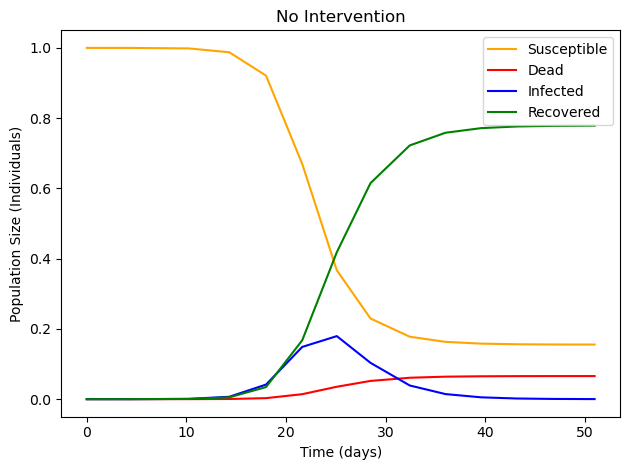

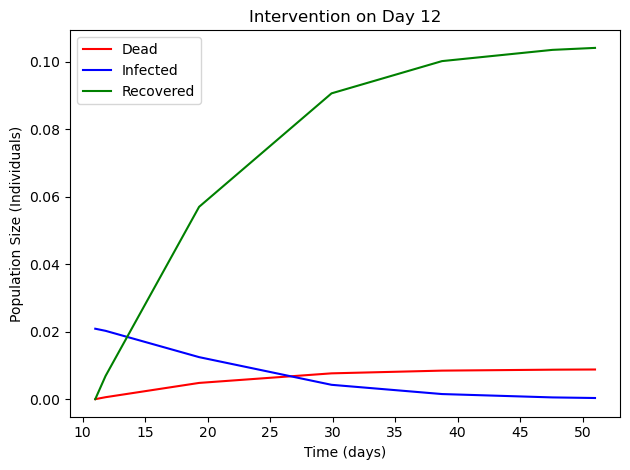

In [113]:
# Plot your results
plt.plot(sol_no_int.t, sol_no_int.y[0], color = 'orange', label = 'Susceptible')
plt.plot(sol_no_int.t, sol_no_int.y[3], color = 'red', label = 'Dead')
plt.plot(sol_no_int.t, sol_no_int.y[1], color = 'blue', label = 'Infected')
plt.plot(sol_no_int.t, sol_no_int.y[2], color = 'green', label = 'Recovered')
plt.title("No Intervention")
plt.xlabel("Time (days)")
plt.ylabel("Population Size (Individuals)")
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(sol_w_int.t, sol_w_int.y[3], color = 'red', label = 'Dead')
plt.plot(sol_w_int.t, sol_w_int.y[1], color = 'blue', label = 'Infected')
plt.plot(sol_w_int.t, sol_w_int.y[2], color = 'green', label = 'Recovered')
plt.title("Intervention on Day 12")
plt.xlabel("Time (days)")
plt.ylabel("Population Size (Individuals)")
plt.legend()

plt.tight_layout()
plt.show()

For more information on how the solve_ivp function works, see:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

# Problem 3: PCA, tSNE, and UMAP

For this problem, you will simply be plotting a dataset of three clusters with PCA, tSNE, and UMAP.

## Step 1: Load the data



## <font color='red'>Student Input Cell: 1 point</font> 

In [114]:
# Raw Data
data = np.loadtxt('/Users/cmdb/Desktop/QBIO2_lab/lab_2/Embed_input.txt', delimiter='\t')

## Step 2: Plot in 3D  

The embed text file has 3,000 rows and 3 columns. The the 3 columns are the 3 coordinates (x,y,z). The rows are data points. Plot the first, second and third thousand rows a different color.

To plot in 3D:

`fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter()`

## <font color='red'>Student Input Cell: 5 points</font> 

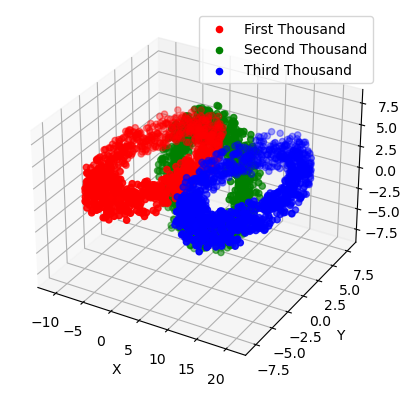

In [118]:
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

one_thousand = data[:1000]
two_thousand = data[1000:2000]
three_thousand = data[2000:3000]


# Scatter plot for each set of points with different colors
ax.scatter(one_thousand[:,0], one_thousand[:,1], one_thousand[:,2], c='red', label='First Thousand')
ax.scatter(two_thousand[:,0], two_thousand[:,1], two_thousand[:,2], c='green', label='Second Thousand')
ax.scatter(three_thousand[:,0], three_thousand[:,1], three_thousand[:,2], c='blue', label='Third Thousand')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

## Step 3: Plot the first two PCA coordinates for the data  

Use the PCA function to embed the data in 2D:

`pca = PCA(n_components=2)
pca.fit(data)
pca_embedded = pca.transform(data)`

## <font color='red'>Student Input Cell: 5 points</font> 

<function matplotlib.pyplot.show(close=None, block=None)>

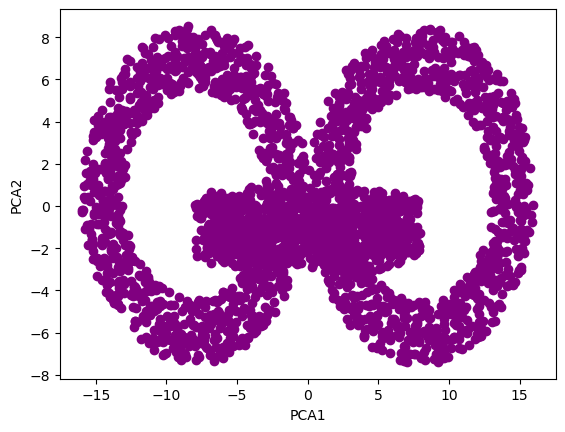

In [127]:
# PCA
pca = PCA(n_components=2)
pca.fit(data)
pca_embedded = pca.transform(data)

plt.scatter(pca_embedded[:,0], pca_embedded[:,1], color = 'purple')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show

For more information about the PCA function, see:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

## Step 4: Plot the data in 2D using tSNE  

As you can see from the plots, the three clusters are distinct, but not spherical. PCA has a tough time with them. In the code below, I use tSNE with perplexity set to 30. Modify the code to plot what the embedding looks like when you set the perplexity to 2, 30, 50, or 100.

`tsne_embedded = TSNE(n_components=2,perplexity=30).fit_transform(data)`

`tsne_embedded` will produce an array with 3000 rows and 2 columns for the two tSNE coordinates.

## <font color='red'>Student Input Cell: 5 points</font> 

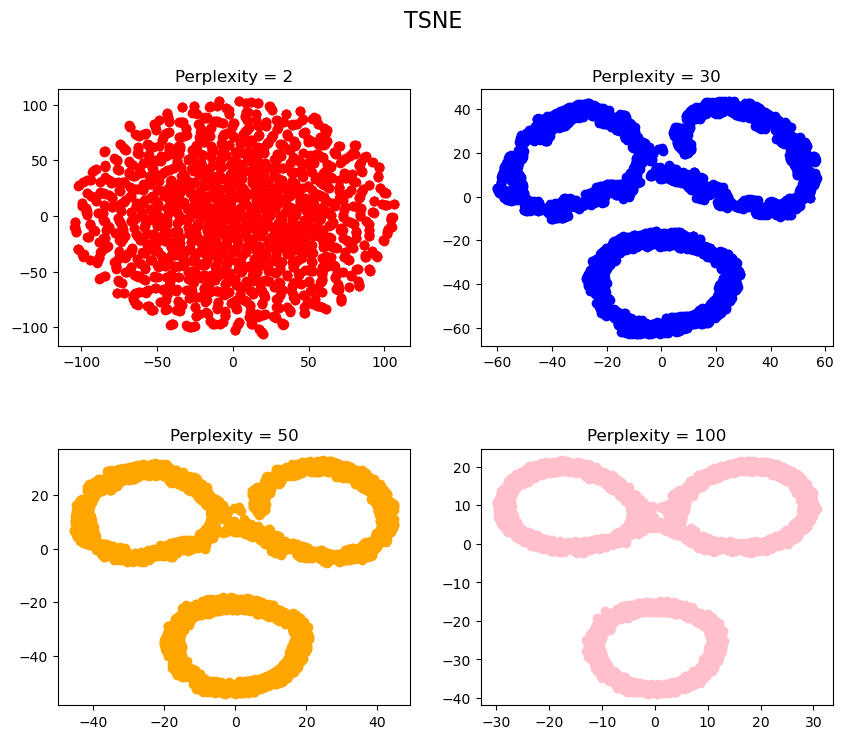

21.0  seconds


In [138]:
# TSNE
start = time.time()


tsne_embedded = TSNE(n_components=2,perplexity=2).fit_transform(data)
tsne_embedded1 = TSNE(n_components=2,perplexity=30).fit_transform(data)
tsne_embedded2 = TSNE(n_components=2,perplexity=50).fit_transform(data)
tsne_embedded3 = TSNE(n_components=2,perplexity=100).fit_transform(data)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0.4})

# Scatter plots for each perplexity value
ax1.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], color='red')
ax1.set_title('Perplexity = 2')
ax2.scatter(tsne_embedded1[:, 0], tsne_embedded1[:, 1], color='blue')
ax2.set_title('Perplexity = 30')
ax3.scatter(tsne_embedded2[:, 0], tsne_embedded2[:, 1], color='orange')
ax3.set_title('Perplexity = 50')
ax4.scatter(tsne_embedded3[:, 0], tsne_embedded3[:, 1], color='pink')
ax4.set_title('Perplexity = 100')


fig.suptitle("TSNE", fontsize=16, y=0.98)

# Show the plot
plt.show()

end = time.time()
elapsed = np.round(end - start)
print(elapsed,' seconds')

For more information about the tSNE package, see:
    
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

## Step 5: Plot the data in 2D using UMAP  

Whew, that took a while! As you can see from the plots, you can make the clusters fairly distinct if you choose the right perplexity. We're going to try the same thing with UMAP, and change the "n_neighbors" option. In the code below, I use UMAP with n_neighbors set to 30. Modify the code to plot what the embedding looks like when you set the perplexity to 2, 30, 50, or 100.

`reducer = umap.UMAP(n_neighbors=30)
umap_embedded = reducer.fit_transform(data)`

`umap_embedded` will produce an array with 3000 rows and 2 columns for the two tSNE coordinates.

## <font color='red'>Student Input Cell: 5 points</font> 

16.0  seconds


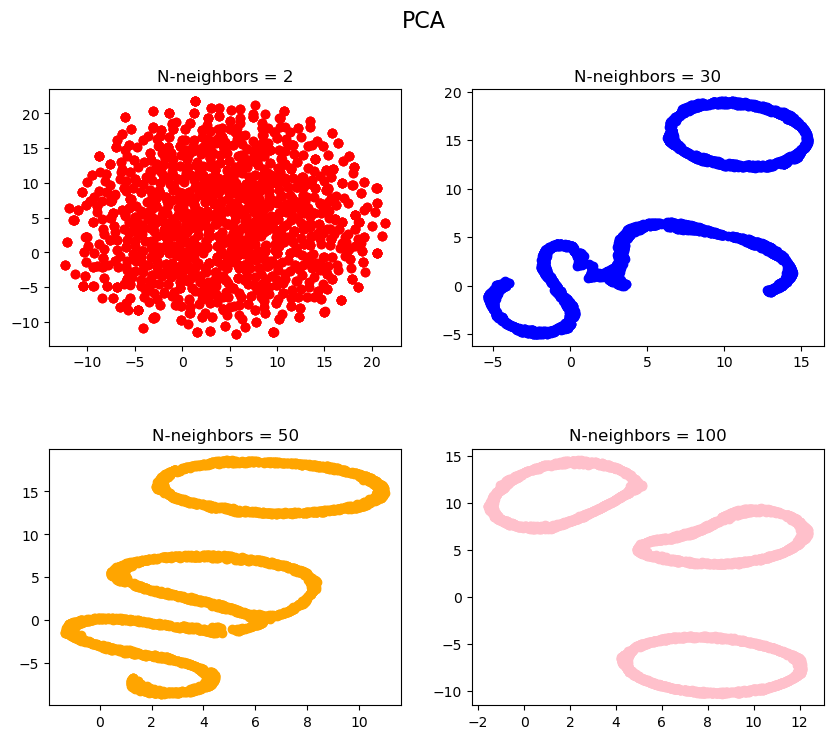

In [139]:
start = time.time()

reducer1 = umap.UMAP(n_neighbors=2)
umap_embedded1 = reducer1.fit_transform(data)

reducer2 = umap.UMAP(n_neighbors=30)
umap_embedded2 = reducer2.fit_transform(data)

reducer3 = umap.UMAP(n_neighbors=50)
umap_embedded3 = reducer3.fit_transform(data)

reducer4 = umap.UMAP(n_neighbors=100)
umap_embedded4 = reducer4.fit_transform(data)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  figsize=(10, 8), gridspec_kw={'hspace': 0.4})

# Scatter plots for each perplexity value
ax1.scatter(umap_embedded1[:, 0], umap_embedded1[:, 1], color='red')
ax1.set_title('N-neighbors = 2')
ax2.scatter(umap_embedded2[:, 0], umap_embedded2[:, 1], color='blue')
ax2.set_title('N-neighbors = 30')
ax3.scatter(umap_embedded3[:, 0], umap_embedded3[:, 1], color='orange')
ax3.set_title('N-neighbors = 50')
ax4.scatter(umap_embedded4[:, 0], umap_embedded4[:, 1], color='pink')
ax4.set_title('N-neighbors = 100')


fig.suptitle("PCA", fontsize=16, y=0.98)


end = time.time()

elapsed = np.round(end - start)
print(elapsed,' seconds')


For more information about the UMAP library, see:

https://umap-learn.readthedocs.io/en/latest/index.html